In [3]:
set.seed(2025)
suppressPackageStartupMessages(require(rstan))
suppressPackageStartupMessages(require(ggplot2))
suppressPackageStartupMessages(require(dplyr))

### Q1: Calibration analysis via cross-validation

In [ ]:
# 2
df = read.csv(url("https://github.com/UBC-Stat-ML/web447/raw/0d6eaa346d78abe4cd125e8fc688c9074d6331d9/data/hubble-1.csv")) %>%
  rename(distance = R..Mpc.) %>%
  rename(velocity = v..km.sec.)
df$velocity = df$velocity/1000

In [9]:
N_obs = nrow(df)
N_train = N_obs-1
train_test_dta = list(
    N  = N_train,
    xs = df$distance[-N_obs], 
    ys = df$velocity[-N_obs], 
    x_pred = df$distance[N_obs]
)

In [30]:
fit = sampling(stan_model("hubble_predict.stan"), 
data=list(N=train_test_dta$N, ys=train_test_dta$ys, xs=train_test_dta$xs, x_pred=train_test_dta$x_pred), 
iter=5000, control = list(max_treedepth = 15))


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 1.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.17 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.057 seconds (Warm-up)
Chain 1:                0.045 seconds (Sampling)
Chain 1:                0.10

In [34]:
as.vector(quantile(extract(fit)$y_pred, prob=c(0.1, 0.9)))

[1] 0.4852019 1.1332459

In [37]:
# 3
ci_limits = matrix(, nrow = N_obs, ncol = 2)
for (i in (1:N_obs)) {
    trained = list(N=N_train, xs=df$distance[-i], ys=df$velocity[-i], x_pred=df$distance[i])
    fit_i = sampling(stan_model("hubble_predict.stan"), 
    data=list(N=trained$N, ys=trained$ys, xs=trained$xs, x_pred=trained$x_pred), 
    iter=5000, control = list(max_treedepth = 15))
    ci_limits[i,] = as.vector(quantile(extract(fit_i)$y_pred, prob=c(0.1, 0.9)))
}


SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 6e-06 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.06 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 5000 [  0%]  (Warmup)
Chain 1: Iteration:  500 / 5000 [ 10%]  (Warmup)
Chain 1: Iteration: 1000 / 5000 [ 20%]  (Warmup)
Chain 1: Iteration: 1500 / 5000 [ 30%]  (Warmup)
Chain 1: Iteration: 2000 / 5000 [ 40%]  (Warmup)
Chain 1: Iteration: 2500 / 5000 [ 50%]  (Warmup)
Chain 1: Iteration: 2501 / 5000 [ 50%]  (Sampling)
Chain 1: Iteration: 3000 / 5000 [ 60%]  (Sampling)
Chain 1: Iteration: 3500 / 5000 [ 70%]  (Sampling)
Chain 1: Iteration: 4000 / 5000 [ 80%]  (Sampling)
Chain 1: Iteration: 4500 / 5000 [ 90%]  (Sampling)
Chain 1: Iteration: 5000 / 5000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.039 seconds (Warm-up)
Chain 1:                0.047 seconds (Sampling)
Chain 1:                0.086 

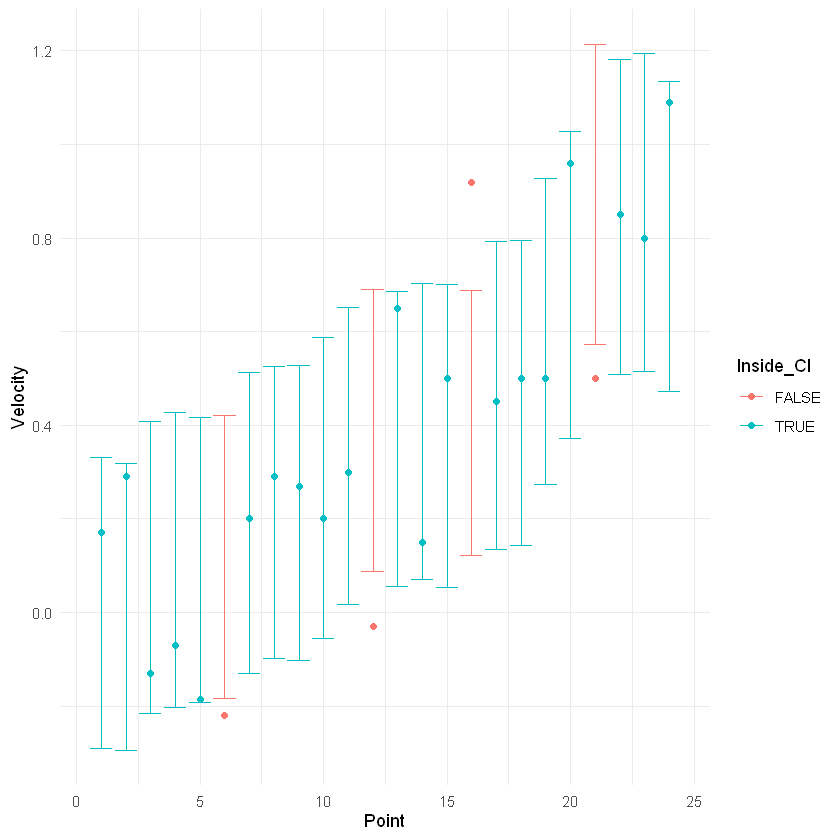

In [39]:
merged_df = df %>% 
  bind_cols(data.frame(CI_L = ci_limits[,1], CI_R = ci_limits[,2])) %>% 
  mutate(Inside_CI = (velocity >= CI_L & velocity <= CI_R)) 
merged_df %>% 
  ggplot(aes(x = 1:N_obs, y = velocity, ymin = CI_L, ymax = CI_R, color=Inside_CI)) +
  geom_point() + 
  geom_errorbar() +
  theme_minimal() +
  labs(x = "Point", y = "Velocity")

### Q2: Estimating asymptotic variance

In [25]:
# simple Metropolis-Hastings algorithm (normal proposal)
simple_mh = function(gamma, initial_point, n_iters, proposal_sd = 1) {
  samples = numeric(n_iters) 
  dim = length(initial_point)
  current_point = initial_point
  for (i in 1:n_iters) {
    proposal = rnorm(dim, mean = current_point, sd = proposal_sd) 
    ratio = gamma(proposal) / gamma(current_point)
    if (runif(1) < ratio) {
      current_point = proposal
    } else {
      # rejection, nothing to do, i.e. we stay at the current point
    }
    # no matter if we reject or not, accumulate one sample
    samples[i] = current_point
  }
  return(samples)
}

In [26]:
estimate_asymptotic_variance = function(gamma, proposal_sd, C, S) {
    sum_E = 0
    sum_Ec_sq = 0
    init_so_far = numeric(C)
    counter = 0
    for (c in (1:C)) {    
        init_pt = rnorm(1, 0, 1)
        while (init_pt %in% init_so_far) {
            init_pt = rnorm(1, 0, 1)
        }
        counter = counter + 1
        init_so_far[counter] = init_pt
        E_c = mean(simple_mh(gamma, init_pt, S, proposal_sd))
        sum_E = sum_E + E_c * S
        sum_Ec_sq = sum_Ec_sq + E_c^2
    }
    return ((S/C)*sum_Ec_sq - S*(sum_E/(C*S))^2)
}

In [40]:
gamma = function(x) exp((-1 / 2) * x^2)
proposal_sd_values = 2^seq(-10, 10, 1)
n = length(proposal_sd_values)
res = numeric(n)
for (i in (1:n)) {
    res[i] = estimate_asymptotic_variance(gamma, proposal_sd_values[i], 100, 1000)
}
df = data.frame(estimated_mcmc_variance= res, proposal_sd = proposal_sd_values)

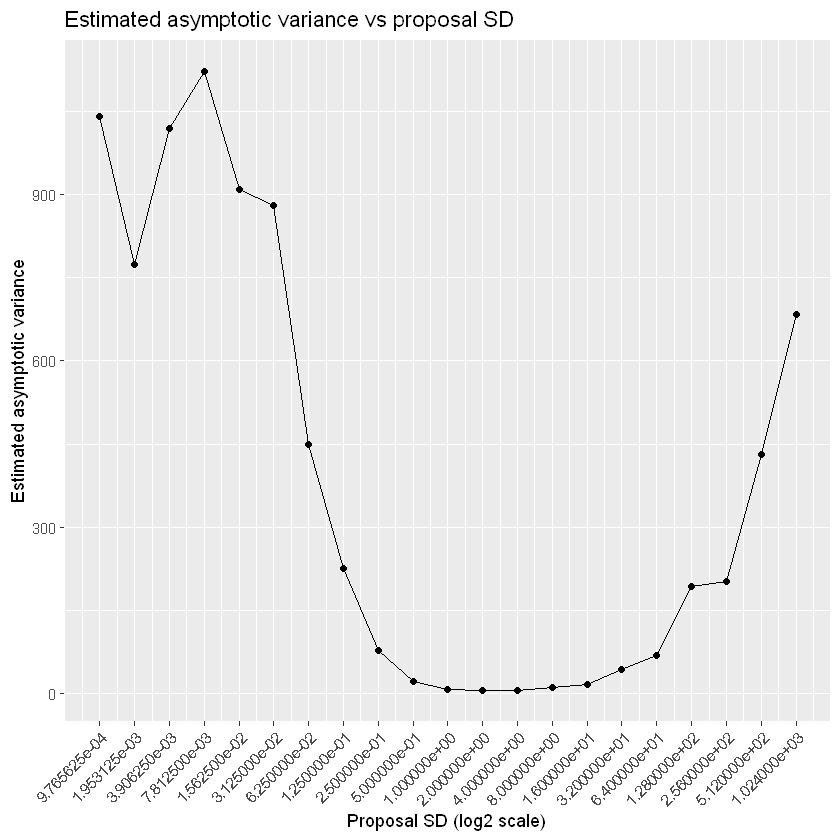

In [41]:
library(ggplot2)
ggplot(df, aes(x = proposal_sd, y = estimated_mcmc_variance)) +
  geom_line() +
  geom_point() +
  scale_x_continuous(trans = "log2", breaks = proposal_sd_values) +
  labs(x = "Proposal SD (log2 scale)",
       y = "Estimated asymptotic variance",
       title = "Estimated asymptotic variance vs proposal SD") + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [ ]:
#3
# prior: Beta(alpha, beta)
alpha = 1
beta = 2 

# observations: binomial draws
n_successes = 3 
n_trials = 3

gamma_beta_binomial = function(p) {
    if (p < 0 || p > 1) {
        return(0.0)
    }
    dbeta(p, alpha, beta) * dbinom(x = n_successes, size = n_trials, prob = p)
}

# simple Metropolis-Hastings algorithm (normal proposal)
simple_mh = function(gam, initial_point, n_iters) {
  samples = numeric(n_iters) 
  dim = length(initial_point)
  curr = initial_point
  # gamma(x) == 0 ==> ratio undefined; while gamma(x') = 0 only makes repeated samples
  # exception handling
  if (gam(curr) == 0) {
    print("Invalid initial point!")
    return(samples)
  }
  for (i in 1:n_iters) {
    proposed = rnorm(dim, curr, 1)
    accept_prob = min(1, gam(proposed)/gam(curr))
    u = runif(1, 0, 1)
    if (u <= accept_prob) {
      samples[i] = proposed
      curr = proposed
    }
    else {
      samples[i] = curr
    }
  }
  return(samples)
}